In [2]:
from opensees import uniaxial
from numpy import sin, linspace, pi, sqrt
from opensees.units.english import ksi, psi
import numpy as np 

import matplotlib.pyplot as plt
try:
    # Try loading a plotting style that may not be installed
    plt.style.use("typewriter")
except:
    pass


def mark_slope(ax, line, a, b, iend=-1, label=None, loc="left", **kwds):
    """
    Annotate a line (curve) with two perpendicular lines that highlight the slope.
    
    Parameters:
      ax    : A Matplotlib axes instance.
      line  : A Line2D object (result of ax.plot()) from which we extract data.
      a, b  : Two y-values (floats) indicating parts of the curve to annotate.
              The function will choose the points on the curve whose y-data 
              are closest to a and b respectively.
      label : Optional text label to display at the annotation corner.
      loc   : Currently only "left" is implemented.
      **kwds: Additional keyword arguments passed to ax.hlines/vlines (e.g., color, linestyle).
      
    Behavior for loc == "left":
      - If the slope (computed from the two chosen points) is positive,
        a vertical line is drawn from the point corresponding to a (point A)
        up to the level of point B, and a horizontal line is drawn from point B
        leftward to meet the vertical line.
      - If the slope is negative, the horizontal line comes off point A (leftward)
        and the vertical line comes off point B (upward or downward) so they meet.
        
    The default linewidth for the annotation lines is set to the linewidth of the original line,
    although you can override this by passing your own value in **kwds.
    """
    # Extract data from the line
    xdata = line.get_xdata()
    ydata = line.get_ydata()
    
    # Find the indices of the points on the curve whose y-data are closest to a and b
    idx_a = np.abs(ydata - a)[:iend].argmin()
    idx_b = np.abs(ydata - b)[:iend].argmin()
    
    # The corresponding (x, y) coordinates on the curve
    x_a, y_a = xdata[idx_a], ydata[idx_a]
    x_b, y_b = xdata[idx_b], ydata[idx_b]
    
    # Set default linewidth for annotation lines if not provided
    lw = line.get_linewidth()
    if 'linewidth' not in kwds and 'lw' not in kwds:
        kwds['linewidth'] = lw

    # Compute the slope between the two chosen points.
    # (If the x coordinates are identical, we set slope to infinity.)
    if x_b == x_a:
        slope = np.inf
    else:
        slope = (y_b - y_a) / (x_b - x_a)
    
    # Annotation for loc == "left"
    if loc == "left":
        if slope > 0:
            # For a positive slope:
            #  - Use the point corresponding to a as the base of a vertical line.
            #  - Use the point corresponding to b as the base of a horizontal line.
            # They meet at the corner (x_a, y_b).
            ax.vlines(x_a, min(y_a, y_b), max(y_a, y_b), **kwds)
            ax.hlines(y_b, min(x_a, x_b), max(x_a, x_b), **kwds)
            if label:
                # Place the label at the corner; adjust alignment as needed.
                ax.text(x_a, y_b, label, va="bottom", ha="right")
        else:
            # For a negative slope:
            #  - Use the point corresponding to a as the base of a horizontal line.
            #  - Use the point corresponding to b as the base of a vertical line.
            # They meet at the corner (x_b, y_a).
            ax.hlines(y_a, min(x_a, x_b), max(x_a, x_b), **kwds)
            ax.vlines(x_b, min(y_a, y_b), max(y_a, y_b), **kwds)
            if label:
                ax.text(x_b, y_a, label, va="bottom", ha="left")
    elif loc == "right":
        if slope > 0:
            # Slope positive:
            # Swap roles compared to loc=="left":
            # - Horizontal line from point A (y_a) rightward from x_a to x_b.
            # - Vertical line from point B (x_b) from y_a to y_b.
            ax.hlines(y_a, min(x_a, x_b), max(x_a, x_b), **kwds)
            ax.vlines(x_b, min(y_a, y_b), max(y_a, y_b), **kwds)
            if label:
                ax.text(x_b, y_a, label, va="top", ha="left")
        else:
            # Slope negative:
            # - Vertical line from point A (x_a) from y_b to y_a.
            # - Horizontal line from point B (y_b) rightward from x_a to x_b.
            ax.vlines(x_a, min(y_a, y_b), max(y_a, y_b), **kwds)
            ax.hlines(y_b, min(x_a, x_b), max(x_a, x_b), **kwds)
            if label:
                ax.text(x_a, y_b, label, va="top", ha="right")
    else:
        raise NotImplementedError("Only loc=='left' and loc=='right' are implemented.")



In [3]:
Fy  = 66.8*ksi             # steel yield stress
Es  = 29000.*ksi           # modulus of steel

Text(0, 0.5, '$\\sigma/\\sigma_y$')

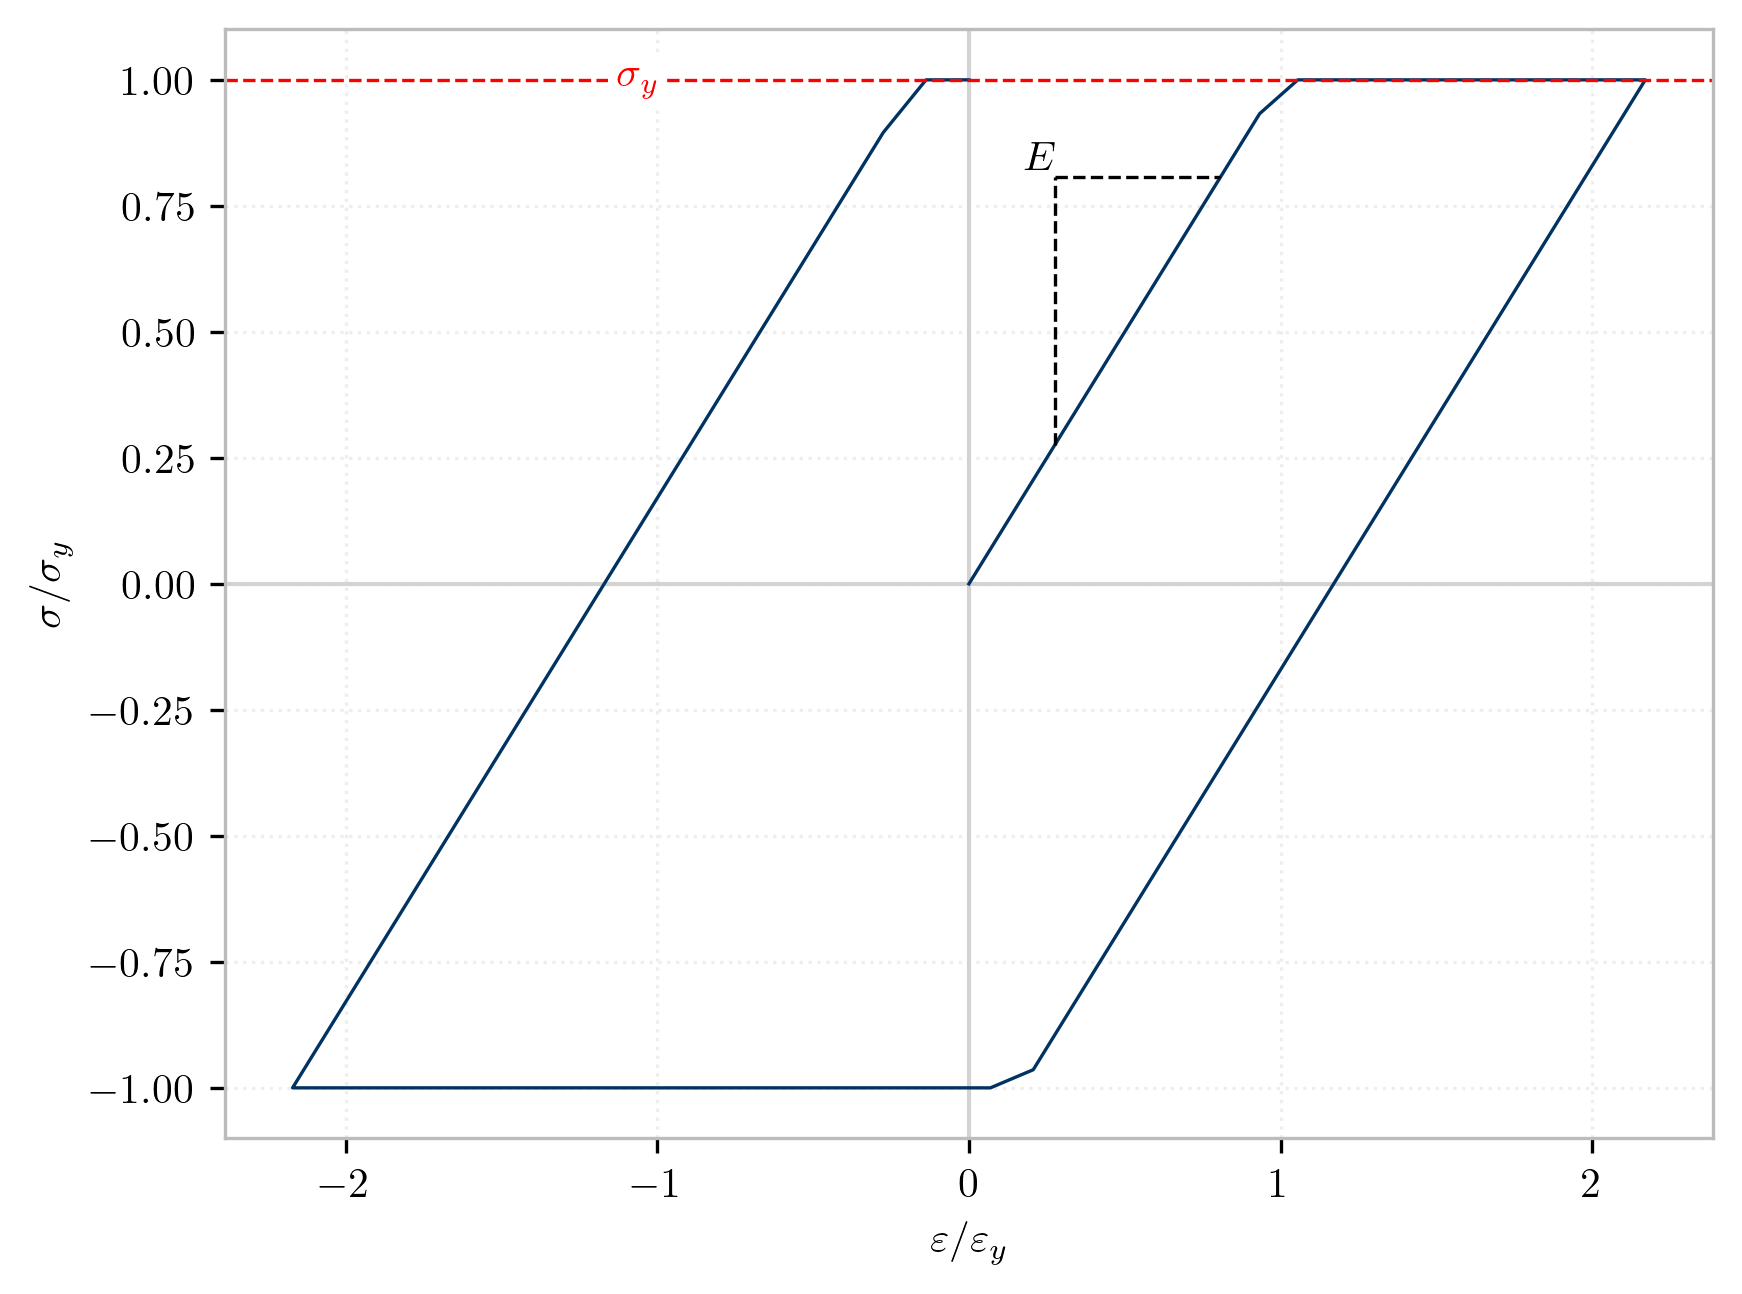

In [4]:

strain = 0.005*sin(linspace(0, 2.0*pi, 100))

stress = []
elastic_pp_material = uniaxial.ElasticPP(Es, Fy/Es)

with elastic_pp_material.handle() as mat:

    for e in strain:
        stress.append(mat.getStress(e, commit=True)/Fy)

# create a plotting figure
fig, ax = plt.subplots()    
ax.axhline(0, color='lightgrey', linestyle='-', linewidth=1)
ax.axvline(0, color='lightgrey', linestyle='-', linewidth=1)
ln = ax.plot(strain/(Fy/Es), stress)

mark_slope(ax, ln[0], 0.25, 0.75, iend=20, label="$E$", color='k', ls='--')
ax.axhline(y=1, color='r', linestyle='--')
ax.text(-1, 1, r"$\sigma_y$", color='r', va='center', ha='right', bbox=dict(facecolor='white', edgecolor='none', pad=2.0))

ax.set_xlabel(r"$\varepsilon/\varepsilon_y$")
ax.set_ylabel(r"$\sigma/\sigma_y$")

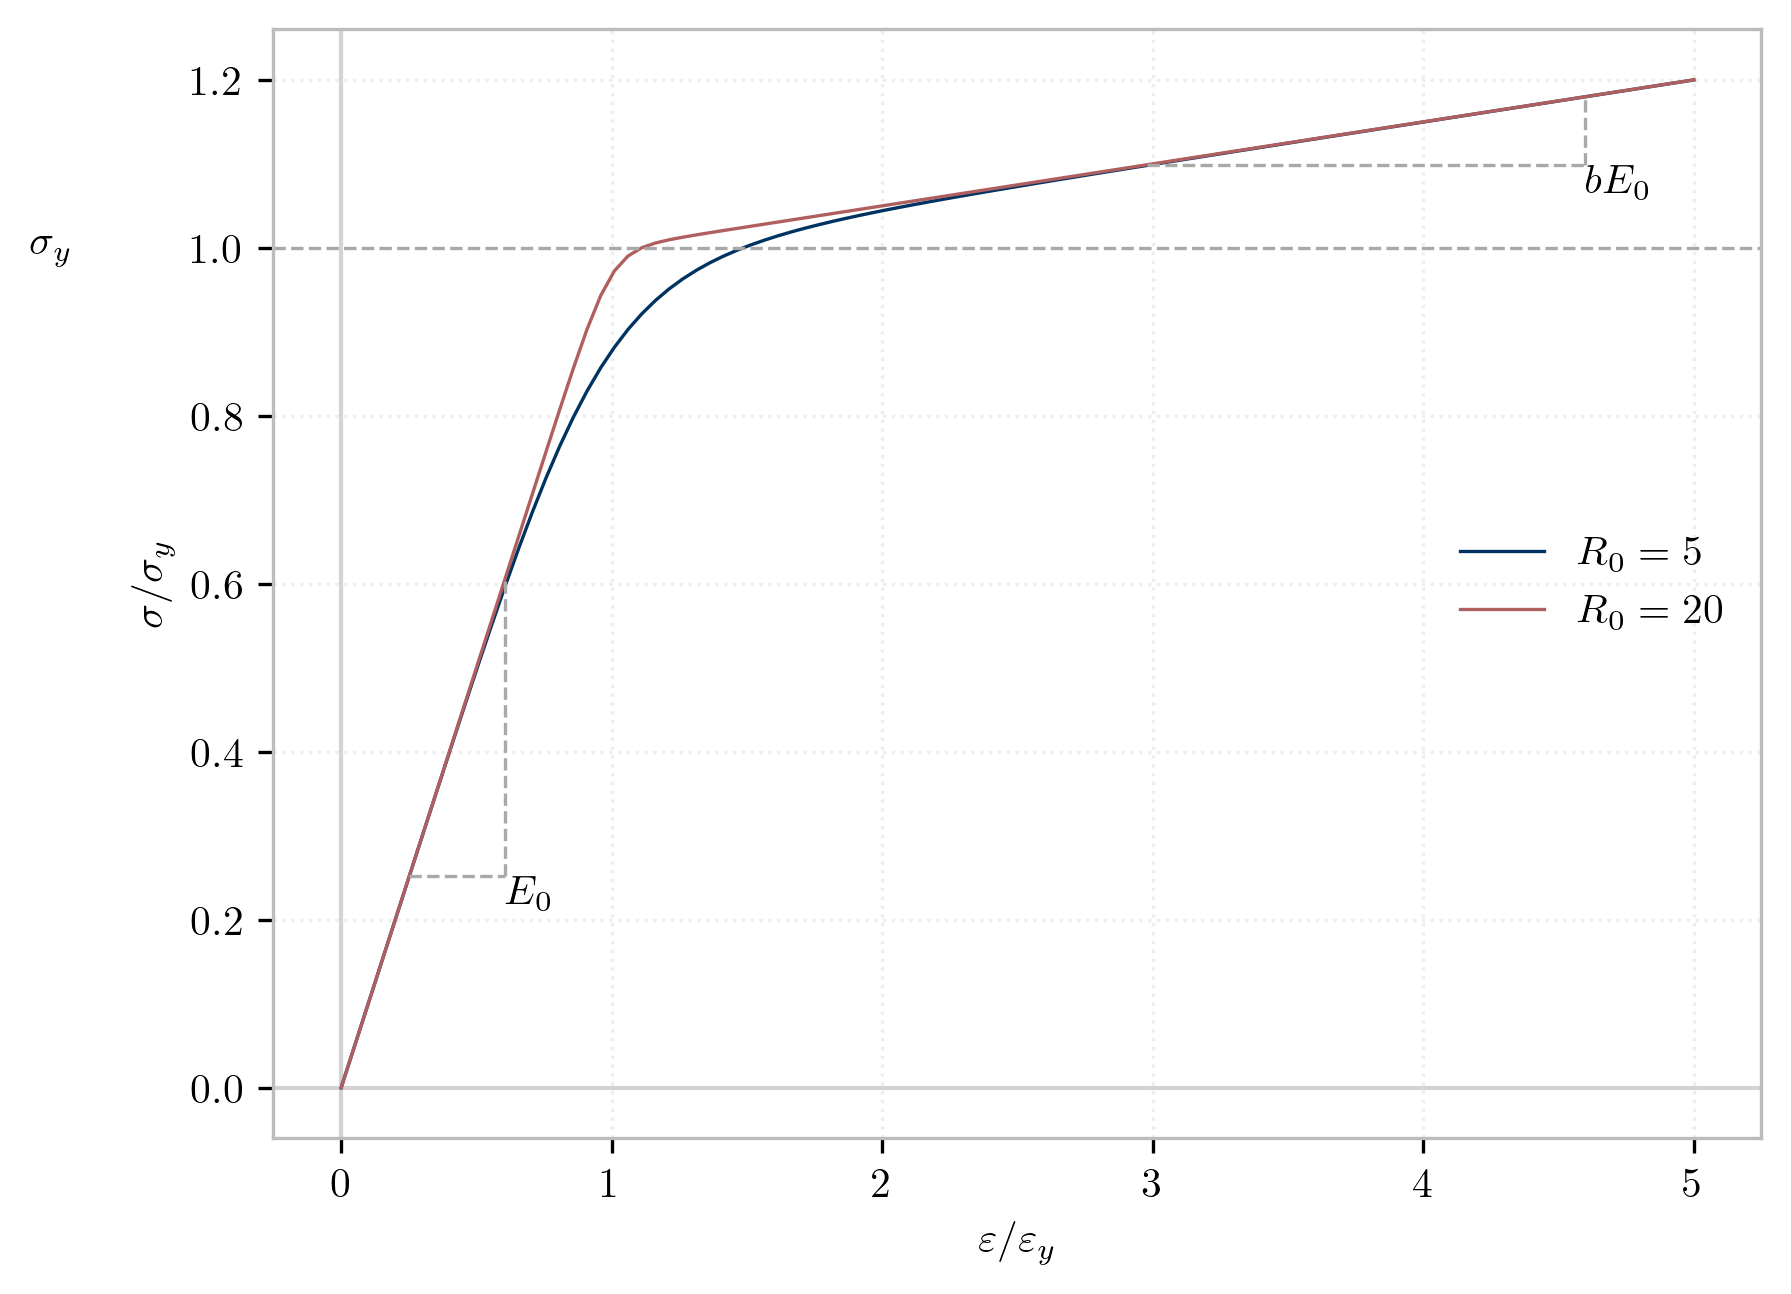

In [5]:
fig, ax = plt.subplots()
ax.axhline(0, color='lightgrey', linestyle='-', linewidth=1)
ax.axvline(0, color='lightgrey', linestyle='-', linewidth=1)

strain = np.linspace(0, Fy/Es*5, 100)

with uniaxial.Steel02(Fy, Es, 0.05, 5).handle() as mat:
    ln = ax.plot(strain/(Fy/Es), 
                 [mat.getStress(e, commit=True)/Fy for e in strain],
                 label="$R_0=5$")

with uniaxial.Steel02(Fy, Es, 0.05, 20).handle() as mat:
    ln = ax.plot(strain/(Fy/Es), 
                 [mat.getStress(e, commit=True)/Fy for e in strain],
                 label="$R_0=20$")

mark_slope(ax, ln[0], 0.25, 0.60, label="$E_0$", color='darkgrey', loc="right", ls='--')
mark_slope(ax, ln[0], 1.1, 1.18, label="$b E_0$", color='darkgrey', loc="right", ls='--')

# Draw a horizontal line at the yield stress Fy
ax.axhline(y=1, color='darkgrey', linestyle='--')
ax.text(-1, 1, r"$\sigma_y$", color='k', va='center', ha='right', bbox=dict(facecolor='white', edgecolor='none', pad=2.0))

ax.set_xlabel(r"$\varepsilon/\varepsilon_y$")
ax.set_ylabel(r"$\sigma/\sigma_y$")
ax.legend()
fig.savefig("figures/Steel02-Backbone.png", dpi=300)

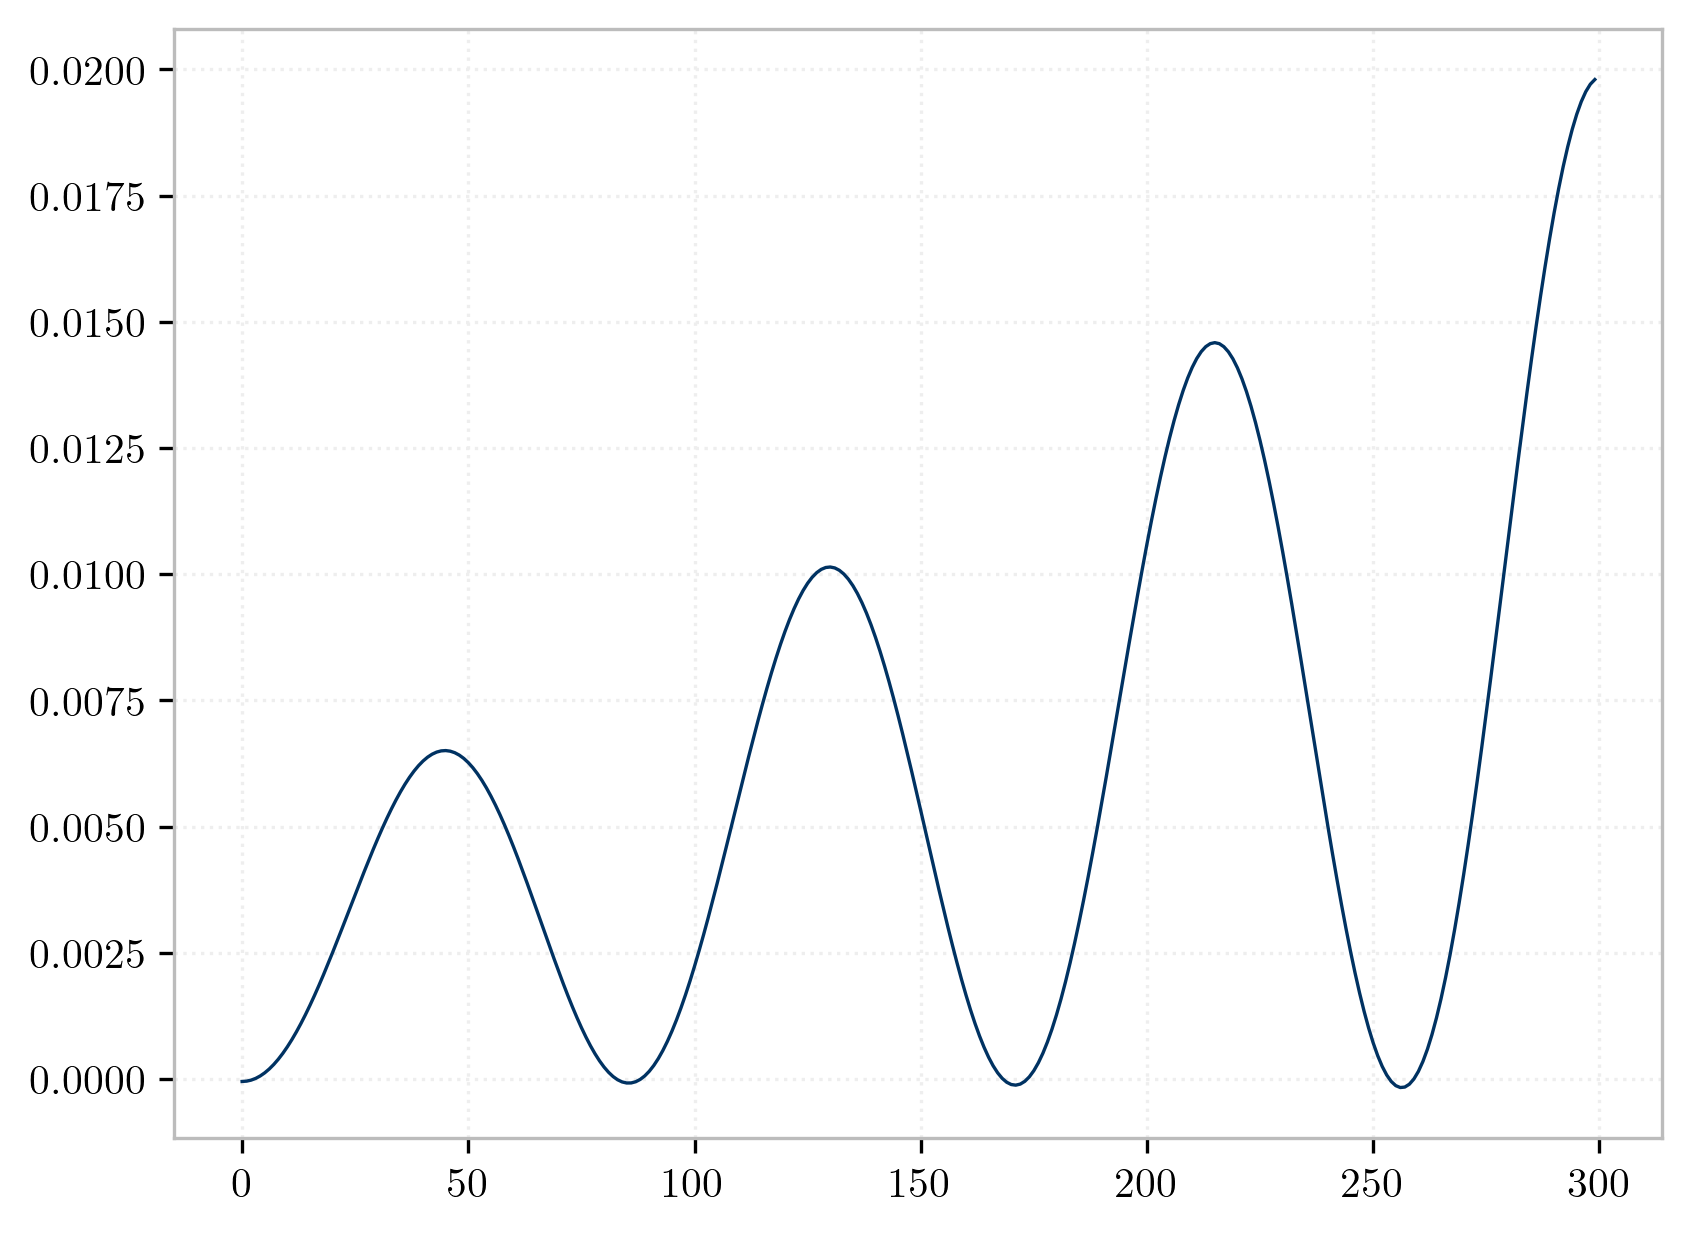

/var/folders/18/xksr_xbx0d59fvx50dwhswkm0000gn/T/ipykernel_25867/2382308240.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


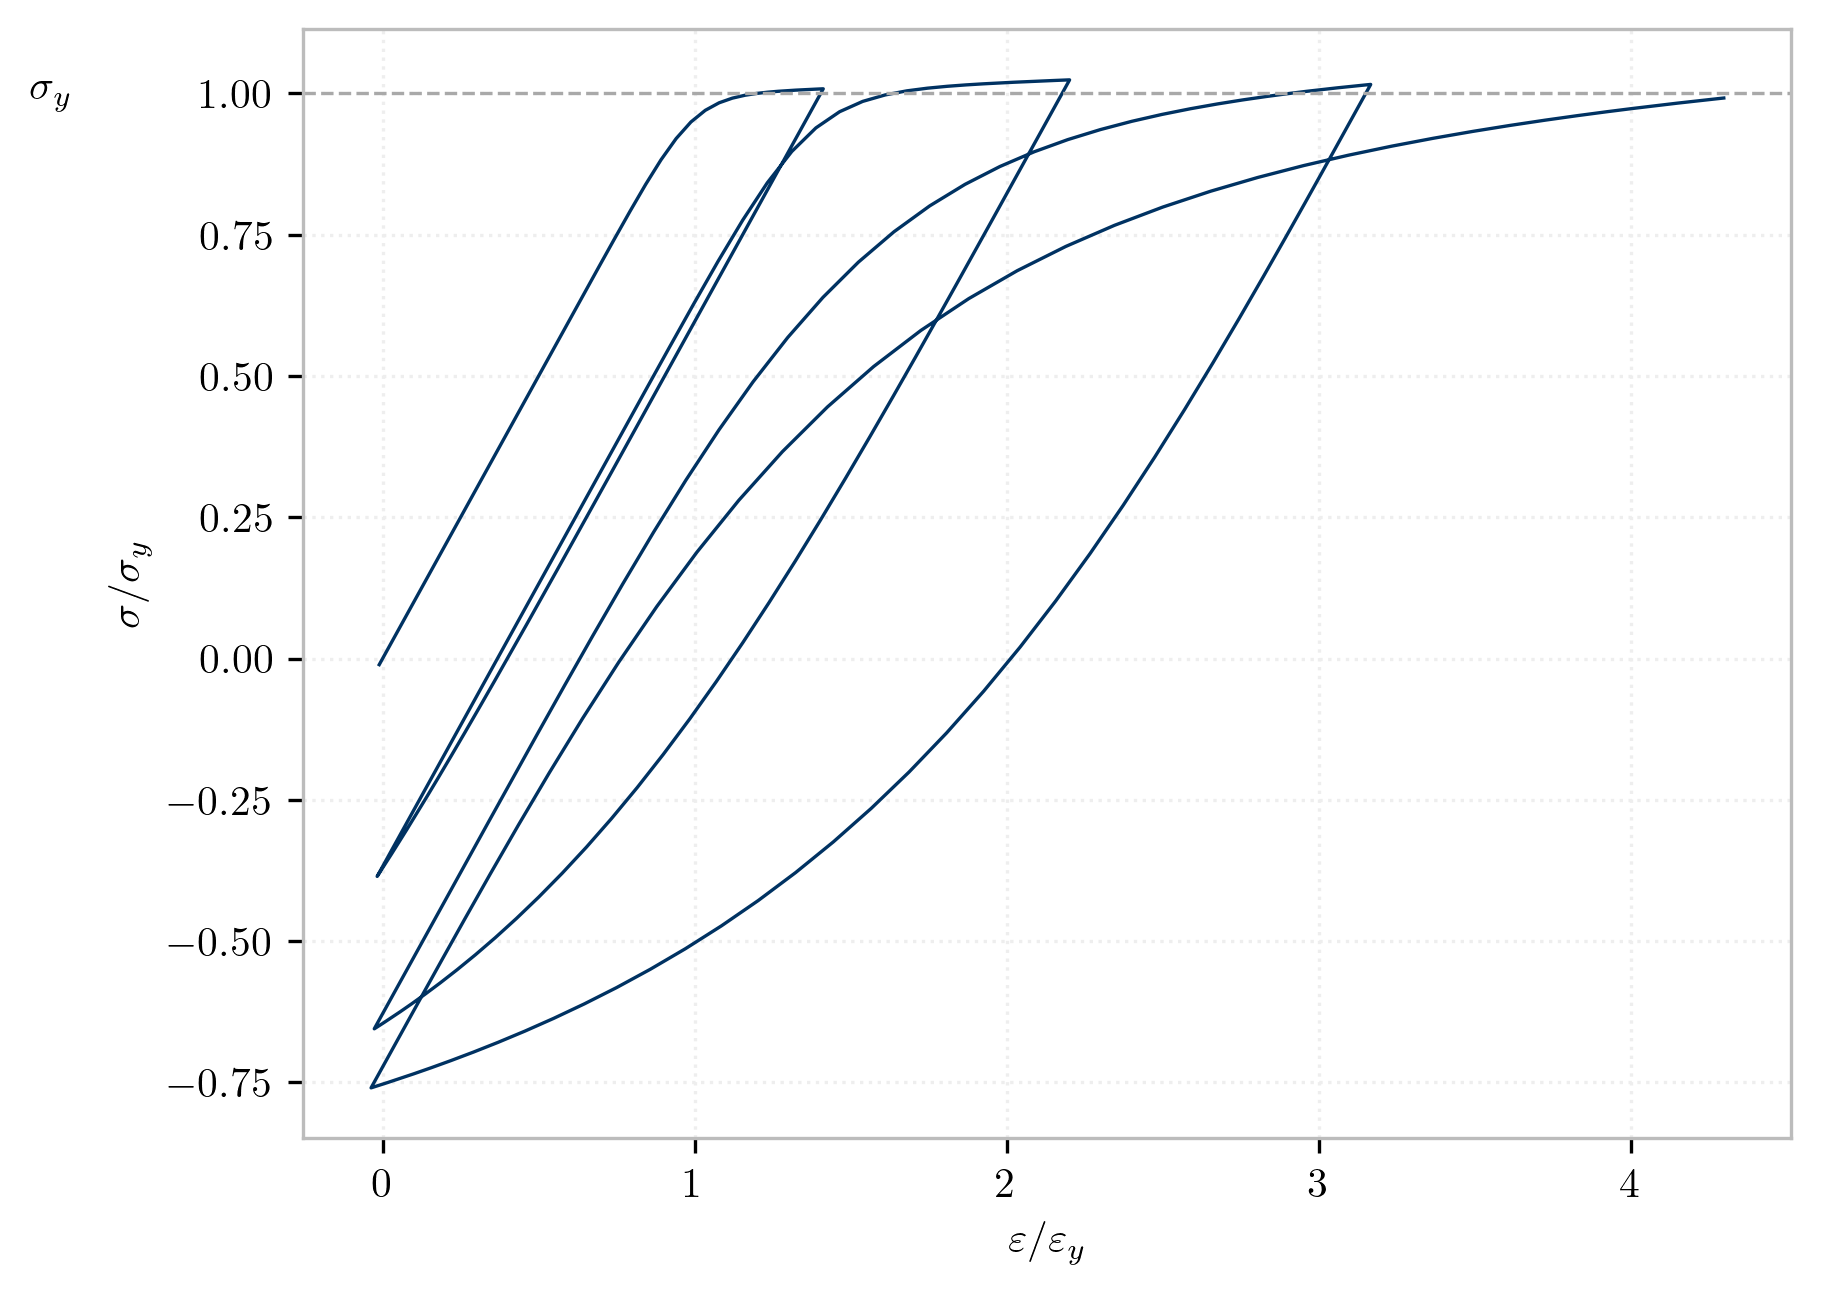

In [16]:

strain = 0.01*(sin(linspace(0, 3.5*pi, 300))**2-0.01)*linspace(0.5, 1, 300)**2


fig, ax = plt.subplots()
with uniaxial.Steel02(Fy, Es, 0.02, 15, 0.925, 0.15, 0.05, 1, 0, 1).handle() as mat:
    ln = ax.plot(strain/(Fy/Es), 
                 [mat.getStress(e, commit=True)/Fy for e in strain],
                 )


# Draw a horizontal line at the yield stress Fy
ax.axhline(y=1, color='darkgrey', linestyle='--')
ax.text(-1, 1, r"$\sigma_y$", color='k', va='center', ha='right', bbox=dict(facecolor='white', edgecolor='none', pad=2.0))

ax.set_xlabel(r"$\varepsilon/\varepsilon_y$")
ax.set_ylabel(r"$\sigma/\sigma_y$")
ax.legend()
fig.savefig("figures/Steel02-Cycling.png", dpi=300)